In [9]:
import os
import warnings

import pandas as pd
import numpy as np


from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
)
from jre_utils.config import asset_types
from jp_prefecture.jp_cities import JpCity, jp_cities
from geopy.geocoders import Nominatim

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [10]:
def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)


def map_time_units(x):
    mapping = {
        "30-60minutes": 45,
        "1H-1H30": 75,
        "1H30-2H": 105,
        "2H-": 135,
    }
    
    return int(x) if x.isdigit() else mapping[x]

def map_layout(x):
    if x == "na":
        return "na"

    x = x.split("+")[0]

    if x[0].isdigit() and int(x[0]) == 1:
        if x != "1K" and x != "1LDK" and x != "1DK":
            return "1other"
        return x
    
    if x[0].isdigit() and int(x[0]) == 2:
        if x != "2LDK" and x != "2DK":
            return "2other"
        return x

    if x[0].isdigit() and int(x[0]) > 2:
        return f"{min(int(x[0]), 5)}LDK"
    
    return "other"

def map_land_shape(x):
    x = x.lower()
    x = x.replace("semi-", "")
    return x

def map_frontage(x):
    if x == "na":
        return 0
    if x == "50.0m or longer.":
        return 55
    return int(x.split(".")[0])

def map_floor_area(x):
    if "less" in x:
        return 10
    elif "greater" in x:
        return 2000
    else:
        return int(x)
    
def map_year_of_construction(x):
    if x == "before the war":
        return 1930
    
    return int(x)

In [11]:
import json
from pprint import pprint

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
     sub_city_to_city = json.load(fd)
     pprint(f"E.g. Maps 1101 to {sub_city_to_city['1101']}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
     area_code_to_area = json.load(fd)
     pprint(f"E.g. Maps 1100 to {area_code_to_area['1100']}") 

def get_city_code(area_code):
     return sub_city_to_city.get(area_code, area_code)

def get_area_from_area_code(area_code):
     return area_code_to_area.get(area_code, "na" )

def get_city_geocode(area_code):
    area_code = str(area_code)
    try:
        return tuple(jp_cities.citycode2geodetic(area_code)) 
    except:
        print(f"Could not find geocode for {area_code}")
        return np.NaN, np.NaN
    
def find_town_jp(all_towns_df, city_code, town_name, log=False):
    city_df = all_towns_df[all_towns_df["cityCode"] == int(city_code)]
    town_df = city_df[city_df["townAlphabet"].str.contains(town_name)]
    
    if town_df.empty:
        if log:
            print(f"JP could not find {town_name} in {city_code}")
        return None, None
    
    return town_df["longitude"].mean(), town_df["latitude"].mean()

def find_town_geopy(geolocator, address, log=False):
    location_info = geolocator.geocode(address)

    if not location_info:
        if log:
            print(f"Geopy could not find {address}")
        return None, None
    
    return location_info.longitude, location_info.latitude

def get_town_coordinates_jp(all_towns_df, city_name, city_code, town_name, log=False):
    geolocator = Nominatim(user_agent="my_app")
    
    # Try to locade in df - this is fast
    jp_lon, jp_lat = find_town_jp(all_towns_df, city_code, town_name, log)

    if not jp_lon or not jp_lat:
        address = f"{town_name}, {city_name}, Japan"
        
        # Fall back and try to locate with geopy - this is slow
        geopy_lon, geopy_lat = find_town_geopy(geolocator, address, log)
        
        if not geopy_lon or not geopy_lat:
            # if nothing works, just return the city coordinates
            return get_city_geocode(city_code)
        
        return geopy_lon, geopy_lat

    return jp_lon, jp_lat



'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [12]:
def process_transactions_df(df):
    df["area_code"] = df["City,Town,Ward,Village code"].astype(str)

    # we may want to skip the following step in the future
    df["area_code"] = df["area_code"].apply(get_city_code).astype(str)
    df["area"] = df["area_code"].apply(get_area_from_area_code)

    df["trade_price"] = df["Transaction-price(total)"]
    df["trade_area"] = df["Area(m^2)"].apply(area_to_int)
    df["unit_price"] = df["Transaction-price(Unit price m^2)"]
    df["trade_price_per_area"] = df["trade_price"] / df["trade_area"]

    df["quarter"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[0][0]))
    df["year"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[2]))

    df["unit_price"] = np.where(
        df["unit_price"].isna(),
        df["trade_price_per_area"],
        df["unit_price"],
    )

    df = df[
        df["Type"].isin(
            [
                asset_types["building"]["label"],
                asset_types["land"]["label"],
                asset_types["condo"]["label"],
            ],
        )
    ]

    # Renaming
    df = df.rename(columns = {
        "Type": "asset_type",
        "Region": "neighbourhood_classification",
        "Area": "subarea",
        "Nearest stationFName": "nearest_station",
        "Nearest stationFDistance(minute)": "time_to_nearest_station",
        "Layout": "layout",
        "Land shape": "land_shape",
        "Frontage": "frontage",
        "Total floor area(m^2)": "total_floor_area",
        "Year of construction": "year_of_construction",
        "Building structure": "building_structure",
        "Use": "use",
        "Purpose of Use": "purpose",
        "Frontage roadFDirection": "frontage_road_direction",
        "Frontage roadFClassification": "frontage_road_classification",
        "Frontage roadFBreadth(m)": "frontage_road_breadth",
        "City Planning": "zone",
        "Maximus Building Coverage Ratio(%)": "max_building_coverage_ratio",
        "Maximus Floor-area Ratio(%)": "max_floor_area_ratio",
        "Renovation": "renovation_status",
        "Transactional factors": "transactional_factors", # need to format and include
    })

    # Process factors
    df["subarea"] = df["subarea"].fillna("")
    df["neighbourhood_classification"] = df["neighbourhood_classification"].fillna("na")
    df["nearest_station"] = df["nearest_station"].fillna("na")
    df["time_to_nearest_station"] = df["time_to_nearest_station"].fillna("30-60minutes").apply(map_time_units)
    df["layout"] = df["layout"].fillna("na").apply(map_layout)
    df["land_shape"] = df["land_shape"].fillna("na").map(map_land_shape)
    df["frontage"] = df["frontage"].fillna("na").apply(map_frontage)

    df["total_floor_area"] = np.where(
        df["total_floor_area"].isna(),
        df["trade_area"].astype(str),
        df["total_floor_area"],
    )

    df["total_floor_area"] = df["total_floor_area"].apply(map_floor_area)

    df["year_of_construction"] = np.where(
        df["year_of_construction"].isna(),
        (df["year"] - 30).astype(str),
        df["year_of_construction"],
    )

    df["year_of_construction"] = df["year_of_construction"].apply(map_year_of_construction)
    df["age"] = (df["year"] - df["year_of_construction"]).apply(lambda x: max(x, 0))

    df["building_structure"] = df["building_structure"].fillna("na")
    df["frontage_road_direction"] = df["frontage_road_direction"].fillna("na")
    df["frontage_road_classification"] = df["frontage_road_classification"].fillna("na")
    df["frontage_road_breadth"] = df["frontage_road_breadth"].fillna("0.0").astype(float)
    df["zone"] = df["zone"].fillna("na")
    df["max_building_coverage_ratio"] = df["max_building_coverage_ratio"].fillna(0)
    df["max_floor_area_ratio"] = df["max_floor_area_ratio"].fillna(0)
    df["renovation_status"] = df["renovation_status"].fillna("na")


    df["use"] = df["use"].fillna("na")
    df["purpose"] = df["purpose"].fillna("na")
    df["transactional_factors"] = df["transactional_factors"].fillna("na")

    df = df.drop(columns = [
        "City,Town,Ward,Village code",
        "City,Town,Ward,Village",
        "Transaction-price(total)",
        "Area(m^2)",
        "Transaction-price(Unit price m^2)",
        "trade_price_per_area",
        "Transaction period",
        "Prefecture",
    ])

    # Convert towns into Longitude and Latitude
    # Move this to global and save in a CSV file.
    # This takes too long to compute
    
    jp_towns = JpCity(enable_town=True)
    towns_df = jp_towns.towns
    towns_df["townAlphabet"] = towns_df["townAlphabet"].fillna("")

    towns_list_df = df[["area", "area_code", "subarea"]].drop_duplicates()
    towns_list_df[["long", "lat"]] = towns_list_df.apply(
        lambda x: pd.Series(get_town_coordinates_jp(towns_df, x["area"], x["area_code"], x["subarea"])),
        axis=1,
    )

    df = df.merge(towns_list_df, on=["area", "area_code", "subarea"], how="left")

    return df

In [13]:
id_columns = ["year"]
metric_columns = ["unit_price_log"]

# land_df.info()

land_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "transactional_factors",
    ],
}

# building_df.info()

building_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "total_floor_area",
        "trade_area",
        "age",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

# condo_df.info()

condo_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "age",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "renovation_status",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

columns_dicts = {
    "land": land_columns,
    "building": building_columns,
    "condo": condo_columns
}

In [24]:
def get_price_index_from_regression(regression_results, prefix=""):
    yearly_results = regression_results.params.filter(like="year_")
    yearly_p_value = regression_results.pvalues.filter(like="year_")

    yearly_results.name = f"{prefix}price_index"
    yearly_p_value.name = f"{prefix}p_value"

    results_df = pd.concat([yearly_results, yearly_p_value], axis=1).round(4)
    results_df = results_df.reset_index().rename(columns={"index": "year"})
    results_df["year"] = results_df["year"].apply(lambda x: x.split("_")[1])
    return results_df


def calculate_price_index(area_df, columns_dict):
    numerical_columns = columns_dict["numerical_columns"]
    categorical_columns = columns_dict["categorical_columns"]
    comma_separated_categorical_columns = columns_dict[
        "comma_separated_categorical_columns"
    ]
    all_unprocessed_columns = (
        numerical_columns + categorical_columns + comma_separated_categorical_columns
    )

    area_df["year"] = area_df["year"].astype(str)
    area_df["quarter"] = area_df["quarter"].astype(str)
    area_df[f"unit_price_log"] = np.log(area_df["unit_price"] + 1)

    # Numerical variables
    scaler = StandardScaler()

    for column in numerical_columns:
        area_df[column] = np.log(area_df[column] + 1)

    area_df[numerical_columns] = scaler.fit_transform(area_df[numerical_columns])

    # Categorical variables
    area_df = pd.get_dummies(
        area_df[all_unprocessed_columns + id_columns + metric_columns],
        columns=categorical_columns,
    )

    # Comma Separated Categorical variables
    for column in comma_separated_categorical_columns:
        one_hot_df = (
            area_df[column]
            .str.replace(" ", "")
            .str.get_dummies(sep=",")
            .rename(columns=lambda x: column + x)
        )
        area_df = pd.concat([area_df, one_hot_df], axis=1)
        area_df = area_df.drop(columns=[column])

    drop_columns = [col for col in area_df.columns if "na" in col]
    area_df = area_df.drop(columns=drop_columns)

    # Model
    X_ord = area_df.drop(columns=id_columns + metric_columns)

    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=0.80)  # Retain p% of the variance
    X_pca = pca.fit_transform(X_ord)

    # Expand years
    yearly_df = area_df[id_columns + metric_columns]
    yearly_df = pd.get_dummies(yearly_df, columns=id_columns)
    yearly_df = pd.concat(
        [
            yearly_df,
            pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(pca.n_components_)]),
        ],
        axis=1,
    )

    X = yearly_df.drop(columns=metric_columns)
    y = yearly_df[metric_columns[0]]

    # Add a constant to the model (the intercept)
    X = sm.add_constant(X)

    # Fit the OLS model
    ordinary_results = sm.OLS(y, X).fit()
    robust_results = sm.RLM(y, X).fit()

    # Compile results
    ordinary_results_df = get_price_index_from_regression(
        ordinary_results, prefix="ols_"
    ).sort_values("year")
    
    robust_results_df = get_price_index_from_regression(
        robust_results, prefix="robust_"
    ).sort_values("year")

    return ordinary_results_df, robust_results_df

In [14]:
prefecture_code = 13
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in sorted(os.listdir(trade_prices_data_path))
]
trade_prices_data_paths[prefecture_code - 1]

'../../data/core/13_Tokyo_20053_20233.csv'

In [16]:
df = pd.read_csv(
    trade_prices_data_paths[prefecture_code - 1],
    encoding="unicode_escape",
    index_col="No",
)

df = process_transactions_df(df)

In [17]:
land_df = df[df["asset_type"] == asset_types["land"]["label"]]
building_df = df[df["asset_type"] == asset_types["building"]["label"]]
condo_df = df[df["asset_type"] == asset_types["condo"]["label"]]

dfs_dict = {
    "land": land_df,
    "building": building_df,
    "condo": condo_df
}

In [25]:
area_code = "13107"
asset_type = "building"
asset_df = dfs_dict[asset_type]
columns_dict = columns_dicts[asset_type]

area_df = asset_df[asset_df["area_code"] == area_code].reset_index(drop=True)
ordinary_results_df, robust_results_df = calculate_price_index(
    area_df, columns_dicts[asset_type]
)

In [26]:
robust_results_df

,year,robust_price_index,robust_p_value
0,2005,0.4709,0.0
1,2006,0.4938,0.0
2,2007,0.6835,0.0
3,2008,0.5615,0.0
4,2009,0.4362,0.0
5,2010,0.4928,0.0
6,2011,0.4737,0.0
7,2012,0.4619,0.0
8,2013,0.4708,0.0
9,2014,0.5313,0.0


In [27]:
ordinary_results_df

,year,ols_price_index,ols_p_value
0,2005,0.4707,0.0
1,2006,0.4880,0.0
2,2007,0.6758,0.0
3,2008,0.5377,0.0
4,2009,0.4530,0.0
5,2010,0.5191,0.0
6,2011,0.4725,0.0
7,2012,0.4496,0.0
8,2013,0.4480,0.0
9,2014,0.5371,0.0


<Axes: xlabel='year'>

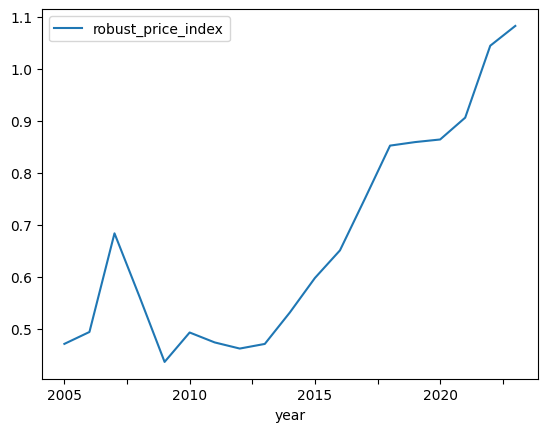

In [28]:
robust_results_df.plot.line(y="robust_price_index", x="year")

<Axes: xlabel='year'>

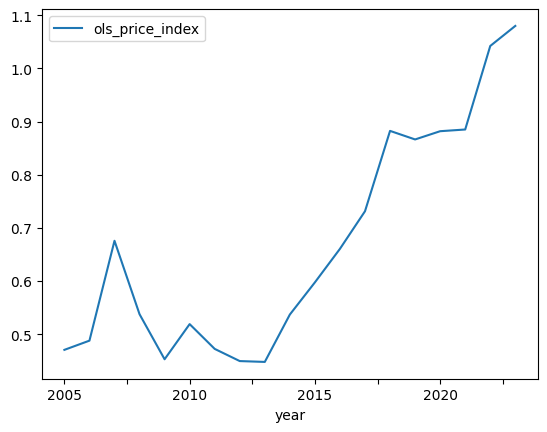

In [29]:
ordinary_results_df.plot.line(y="ols_price_index", x="year")

<Axes: xlabel='year'>

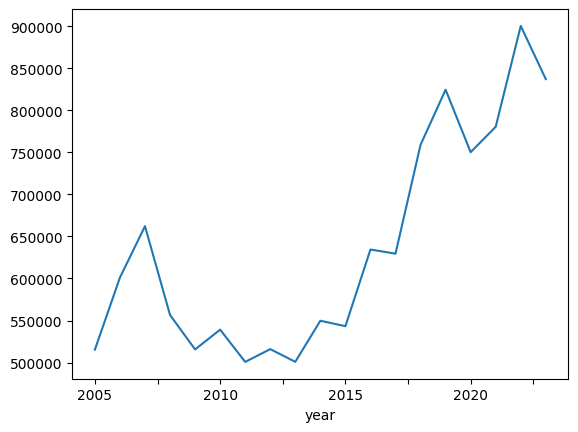

In [31]:
area_df.groupby(["year"])["unit_price"].apply(
    lambda x: np.exp(np.log(x).mean())
).plot.line()